In [334]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import shap
import optuna
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [336]:
db = pd.read_excel("Retail-Supply-Chain-Sales-Dataset.xlsx")

In [337]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Row ID               9994 non-null   int64         
 1   Order ID             9994 non-null   object        
 2   Order Date           9994 non-null   datetime64[ns]
 3   Ship Date            9994 non-null   datetime64[ns]
 4   Ship Mode            9994 non-null   object        
 5   Customer ID          9994 non-null   object        
 6   Customer Name        9994 non-null   object        
 7   Segment              9994 non-null   object        
 8   Country              9994 non-null   object        
 9   City                 9994 non-null   object        
 10  State                9994 non-null   object        
 11  Postal Code          9994 non-null   int64         
 12  Region               9994 non-null   object        
 13  Retail Sales People  9994 non-nul

In [338]:
target = db.iloc[:,[9,4,6,7,11,12] + list(range(16,22))].copy()

In [339]:
target['Duration'] =db['Ship Date']-db['Order Date']
target['Ship Day'] = db['Ship Date'].dt.day
target['Ship Month']= db['Ship Date'].dt.month
target['Order Month'] = db['Order Date'].dt.month
target.sample()

,City,Ship Mode,Customer Name,Segment,Postal Code,Region,Sub-Category,Product Name,Returned,Sales,Quantity,Discount,Duration,Ship Day,Ship Month,Order Month
5827,New York City,Second Class,Katrina Bavinger,Home Office,10035,East,Chairs,Global Low Back Tilter Chair,Not,181.764,2,0.1,92 days,9,6,3


In [340]:
target['Returned']=db['Returned'].map({'Yes':1,'Not':0})
def extract_brand(product_name):
    if isinstance(product_name,str):
        return product_name.split()[0].strip(",").title()
    return "Unknown"
target['Brand']=target['Product Name'].apply(extract_brand)
target['Duration']=target['Duration'].dt.days
target.sample()

,City,Ship Mode,Customer Name,Segment,Postal Code,Region,Sub-Category,Product Name,Returned,Sales,Quantity,Discount,Duration,Ship Day,Ship Month,Order Month,Brand
870,Philadelphia,First Class,Paul Knutson,Home Office,19143,East,Phones,Cisco SPA301,0,280.782,3,0.4,61,9,5,3,Cisco


In [341]:
encoding_cols = ['Ship Mode','Segment','City','Sub-Category','Brand','Region']
for cols in encoding_cols:
    for cols in encoding_cols:
        le = LabelEncoder()
        target[cols] = le.fit_transform(target[cols])
target.drop(columns=['Product Name','Customer Name','Sales'],inplace= True)
target.sample(4)

,City,Ship Mode,Segment,Postal Code,Region,Sub-Category,Returned,Quantity,Discount,Duration,Ship Day,Ship Month,Order Month,Brand
9273,194,3,0,42420,2,3,0,3,0.0,120,9,6,2,170
2260,437,2,2,92024,3,0,0,3,0.0,61,11,10,8,255
7236,266,0,0,90049,3,2,0,3,0.0,92,12,10,7,293
4754,369,3,0,33024,2,3,0,2,0.7,153,2,8,3,170


Accuracy 0.951975987993997


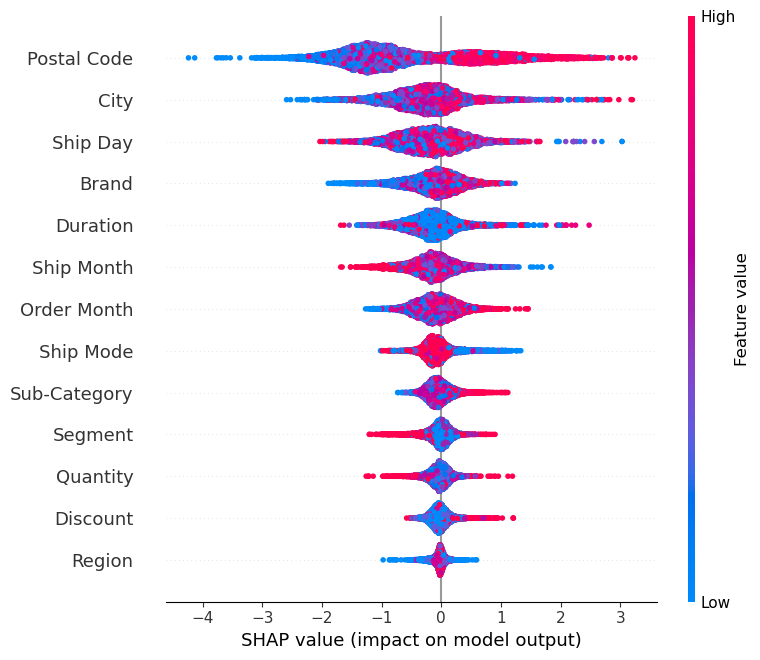

In [342]:
X = target.drop(columns=['Returned'])
y = target['Returned']
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
XGB_test=XGBClassifier(eval_metric='logloss', random_state=42)
XGB_test.fit(x_train,y_train)
acu= accuracy_score(y_test,y_pred)
print("Accuracy",acu)
explainer = shap.TreeExplainer(XGB_test)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values,x_train)
y_pred = XGB_test.predict(x_test)

In [433]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

x_est,x_final,y_est,y_final = train_test_split(x_train,y_train,test_size=0.2,random_state=42,stratify =y_train )
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100,350]),
        'max_depth': trial.suggest_categorical('max_depth', [20,100]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.03,1.0]),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'eval_metric': 'logloss',
        'random_state': 42
    }

    XGB_optuna = XGBClassifier(**params)
    XGB_optuna.fit(x_est, y_est,
             eval_set=[(x_final,y_final)],
             verbose = False)
    y_pred = XGB_optuna.predict(x_final)
    accuracy = accuracy_score(y_final, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=250)

print("Accuracy:", study.best_value)
print("Best Parameters:", study.best_params)

[I 2025-06-24 22:43:20,469] A new study created in memory with name: no-name-4f041d95-3306-44b7-865d-5dd36b1af7b0
[I 2025-06-24 22:43:21,164] Trial 0 finished with value: 0.9212007504690432 and parameters: {'n_estimators': 350, 'max_depth': 20, 'learning_rate': 0.03, 'subsample': 0.9172154494562706, 'colsample_bytree': 0.7978378977731257, 'gamma': 2.419048235246373, 'reg_alpha': 1.1570731093579323, 'reg_lambda': 3.8269294481089524}. Best is trial 0 with value: 0.9212007504690432.
[I 2025-06-24 22:43:21,579] Trial 1 finished with value: 0.9205753595997499 and parameters: {'n_estimators': 350, 'max_depth': 20, 'learning_rate': 0.03, 'subsample': 0.5629216793975385, 'colsample_bytree': 0.9689925238181484, 'gamma': 4.268814878837028, 'reg_alpha': 2.1205499867253814, 'reg_lambda': 1.900417868583646}. Best is trial 0 with value: 0.9212007504690432.
[I 2025-06-24 22:43:21,964] Trial 2 finished with value: 0.9193245778611632 and parameters: {'n_estimators': 350, 'max_depth': 100, 'learning_rat

Accuracy: 0.9437148217636022
Best Parameters: {'n_estimators': 350, 'max_depth': 100, 'learning_rate': 1.0, 'subsample': 0.7656351499894699, 'colsample_bytree': 0.649603590845452, 'gamma': 0.007676737481538715, 'reg_alpha': 0.19336198854203807, 'reg_lambda': 4.71916914819841}


Accuracy:  0.9564782391195598


<function matplotlib.pyplot.show(close=None, block=None)>

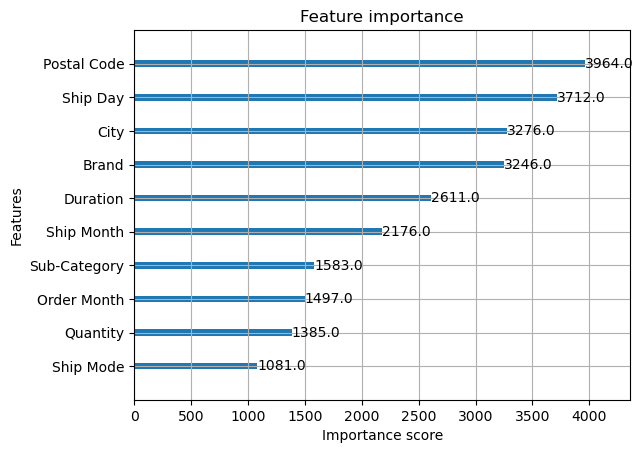

In [439]:
best_case = {
    'n_estimators': 350, 
    'max_depth': 25, 
    'learning_rate': 0.1, 
    'eval_metric':'error',
    'random_state':42,
    'booster':'gbtree',
    
            }
XGB_final = XGBClassifier(**best_case)
XGB_final.fit(x_train,y_train,
       eval_set =[(x_test,y_test)],
       verbose = False)
y_pred = XGB_final.predict(x_test)
acc = accuracy_score(y_test,y_pred)
print("Accuracy: ",acc)
plot_importance(XGB_final,max_num_features=10,importance_type='weight')
plt.show

## Accuracy:  0.951975987993997